In [49]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string

import nltk

In [50]:
df = pd.read_csv('training_data/wav2letter.txt', sep=",", header=None)
df.columns = ["sentence", "label"]
df.head()

,sentence,label
0,had lived nearly twenty one years in the world,0
1,most affectionate indulgent father and had in,1
2,her mother had died too long ago for her to,0
3,have more than an indistinct remembrance of he...,1
4,and her place had been supplied by an excellen...,0


In [51]:
df.groupby("label").describe()

sentence                                                                
         count  unique                                                top freq
label                                                                         
0       178277  177465   not written in the book of the chronicles of the   11
1         1857    1856  ladies and gentlemen i am ordered by miss wood...    2

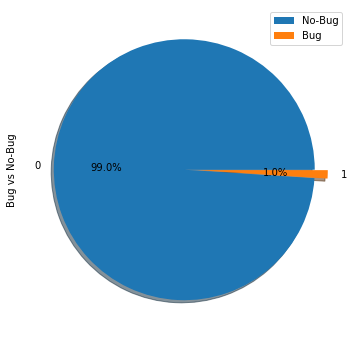

In [52]:
df["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Bug vs No-Bug")
plt.legend(["No-Bug", "Bug"])
plt.show()

### Handle Imbalance Data

In [53]:
from sklearn.utils import resample

In [54]:
# Separate majority and minority classes
df_majority = df[df.label==0]
df_minority = df[df.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()

data = df_upsampled.copy()

### Count Vectorizer

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

In [56]:
from g2p_en import G2p
g2p = G2p()

def text_process(sentence):
    nopunc =[char for char in sentence if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return g2p(nopunc)

In [57]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(data['sentence'])
print(len(bow_transformer.vocabulary_))

70


In [58]:
sample_sentence = data["sentence"][0]
sample_bow = bow_transformer.transform([sample_sentence])
print(sample_sentence)
print(sample_bow.shape)
print(sample_bow)

(1, 70)
  (0, 0)	8
  (0, 5)	1
  (0, 7)	1
  (0, 8)	1
  (0, 17)	1
  (0, 21)	3
  (0, 22)	1
  (0, 24)	1
  (0, 27)	1
  (0, 34)	1
  (0, 35)	1
  (0, 36)	2
  (0, 38)	2
  (0, 43)	3
  (0, 45)	4
  (0, 54)	2
  (0, 57)	2
  (0, 65)	1
  (0, 66)	3
  (0, 67)	1
  (0, 68)	1


In [62]:
print(sample_sentence)

had lived nearly twenty one years in the world


In [59]:
sentence_bow = bow_transformer.transform(data["sentence"])

In [60]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(sentence_bow)
sample_tfidf = tfidf_transformer.transform(sample_bow)
print(sample_tfidf)

  (0, 68)	0.11133478094292543
  (0, 67)	0.17965139347162642
  (0, 66)	0.3347265323915999
  (0, 65)	0.11714519587391749
  (0, 57)	0.15159244054625093
  (0, 54)	0.17988566680164578
  (0, 45)	0.30175592560686215
  (0, 43)	0.2790915783094122
  (0, 38)	0.2720487598991252
  (0, 36)	0.19636264108912668
  (0, 35)	0.11047377761832783
  (0, 34)	0.11309864004587711
  (0, 27)	0.2008126008896905
  (0, 24)	0.10074501348817719
  (0, 22)	0.10016826758975403
  (0, 21)	0.25282536807746775
  (0, 17)	0.1289338230191229
  (0, 8)	0.10902571037641552
  (0, 7)	0.07783191238628619
  (0, 5)	0.10808116131374423
  (0, 0)	0.54500749201032


In [61]:
sentence_tfidf = tfidf_transformer.transform(sentence_bow)

In [63]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(sentence_tfidf,data['label'])

In [64]:
print('predicted:', model.predict(sample_tfidf)[0])
print('expected:',data.label[0])

predicted: 1
expected: 0


In [65]:
all_predictions = model.predict(sentence_tfidf)

In [66]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(data['label'],all_predictions))
print(confusion_matrix(data['label'],all_predictions))

              precision    recall  f1-score   support

           0       0.65      0.62      0.64    178277
           1       0.64      0.67      0.65    178277

    accuracy                           0.64    356554
   macro avg       0.65      0.64      0.64    356554
weighted avg       0.65      0.64      0.64    356554

[[110920  67357]
 [ 59304 118973]]


### Train Test Split

In [67]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data['sentence'], data['label'],test_size=0.4)

### Creating Pipeline

In [68]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
   ( 'bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB()),
])

In [69]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x11490be18>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Prediction

In [70]:
predictions = pipeline.predict(X_test)

In [71]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63     69111
           1       0.66      0.64      0.65     73511

    accuracy                           0.64    142622
   macro avg       0.64      0.64      0.64    142622
weighted avg       0.64      0.64      0.64    142622

